In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Mounted at /gdrive
/gdrive/My Drive


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

2.14.0


In [ ]:
# Conditional check for unzipping
unzip = True  # Set this flag to True to unzip the file

# Unzip the 'public_data.zip' file if the 'unzip' flag is True
if unzip:
    !unzip public_data.zip
    data = np.load('public_data.npz', allow_pickle=True)

image_data=data['data']
image_labels=data['labels']

Archive:  public_data.zip
replace public_data.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
def preprocess_image(data):
    images=[]
    image_data=data['data']
    image_labels=data['labels']
    # Iterate through files in the specified folder
    for image in image_data:

        # Normalize image pixel values to a float range [0, 1]
        image = (image / 255).astype(np.float32)

        # Resize the image to 32x32 pixels
        #image = tfkl.Resizing(128, 128)(image)

        if image is not None:
            images.append(image)


    labels = np.where(image_labels == 'healthy', 0, 1)



    return np.array(images),labels


images,labels=preprocess_image(data)

In [ ]:
def filter_images_by_intensity(images, labels, thresholds):
    # Calculate the average intensity for each image
    filtered_images=[]
    filtered_image_index=[]
    for i in range(len(images)):
      average_intensity = np.mean(images[i])
      mask1 = (thresholds[0] <= average_intensity) & (average_intensity <= thresholds[1])  #shrek images
      mask2 = (thresholds[2] <= average_intensity) & (average_intensity <= thresholds[3])  #trololo images

      if mask1 or mask2:
        filtered_images.append(images[i])
        filtered_image_index.append(i)

      # Use boolean indexing to filter out elements
    filtered_images = np.delete(images, filtered_image_index, axis=0)
    filtered_labels = np.delete(labels, filtered_image_index, axis=0)

    return filtered_images,filtered_labels

thresholds = [0.25200000, 0.2540000000, 0.4440000000000, 0.4450000000]

filtered_images,filtered_labels = filter_images_by_intensity(images, labels, thresholds)


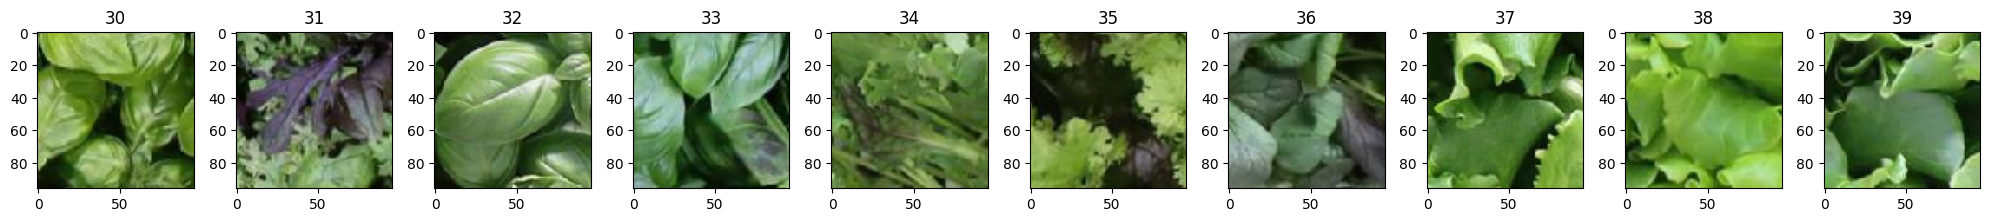

In [ ]:
# Display a sample of images from the training-validation dataset
num_img = 10
z=30
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i%num_img]
    ax.imshow(filtered_images[i+z], cmap='gray')
    ax.set_title(f'{i+z}')  # Show the corresponding digit label

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [ ]:
# Split the data into training (90%) and temporary data (10%)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(filtered_images, filtered_labels, test_size=0.1, random_state=seed)

# Now, split the combined training and validation data into training (90%) and validation (10%)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, random_state=seed, stratify=Y_train_val)


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {Y_test.shape}")

X_train shape: (4041, 96, 96, 3), y_train shape: (4041,)
X_val shape: (450, 96, 96, 3), y_val shape: (450,)
X_test shape: (499, 96, 96, 3), y_test shape: (499,)


In [ ]:
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of target classes:')
print(pd.DataFrame(Y_train_val, columns=['class'])['class'].value_counts())

Counting occurrences of target classes:
0    2808
1    1683
Name: class, dtype: int64


In [ ]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 64
epochs = 100
learning_rate = 1e-4
input_shape = X_train.shape[1:]
output_shape = 1

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

Batch Size: 64, Epochs: 100, Learning Rate: 0.0001
Input Shape: (96, 96, 3), Output Shape: 1


In [ ]:
# Define two callback functions for early stopping and learning rate reduction
# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]

# Print the defined callbacks
print("Callbacks:")
for callback in callbacks:
    print(callback)

Callbacks:


In [ ]:
def VGG16(input_shape, seed=seed):
    tf.random.set_seed(seed)

    preprocessing = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
        tfkl.RandomTranslation(0.2,0.2),
    ], name='preprocessing')

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(64, (3, 3), padding='same')(preprocessing)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    x = tfkl.Conv2D(64, (3, 3), padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    x = tfkl.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = tfkl.Conv2D(128, (3, 3), padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    x = tfkl.Conv2D(128, (3, 3), padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    x = tfkl.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = tfkl.Conv2D(256, (3, 3), padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    x = tfkl.Conv2D(256, (3, 3), padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    x = tfkl.Conv2D(256, (3, 3), padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    x = tfkl.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten the results to feed into a DNN
    x = tfkl.Flatten()(x)

    # 512 neuron hidden layer with dropout
    x = tfkl.Dense(512)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(0.5)(x)

    # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class and 1 for the other class
    output_layer = tfkl.Dense(1, activation='sigmoid')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='VGG16-like_with_dropout')

    # Compile the model with RMSprop optimizer and binary crossentropy loss
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.AdamW(learning_rate, weight_decay=5e-4), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
model = VGG16(input_shape)
model.summary()

Model: "VGG16-like_with_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 conv2d_28 (Conv2D)          (None, 96, 96, 64)        1792      
                                                                 
 batch_normalization_16 (Ba  (None, 96, 96, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 96, 96, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 96, 96, 64)        36928     
                                           

In [ ]:
# Define the number of folds
k_folds = 5

# Create a StratifiedKFold object
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)

# Initialize a list to store the performance metrics for each fold
fold_accuracies = []

# Loop through each fold
for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(X_train, Y_train)):
    print(f'\nTraining on Fold {fold + 1}/{k_folds}...')

    # Split the data into training and validation sets for this fold
    X_fold_train, Y_fold_train = X_train[train_indices], Y_train[train_indices]
    X_fold_val, Y_fold_val = X_train[val_indices], Y_train[val_indices]

    # Build the model
    model = VGG16(input_shape)

    # Compile the model with AdamW optimizer and binary crossentropy loss
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.AdamW(learning_rate, weight_decay=5e-4), metrics=['accuracy'])

    # Train the model on the current fold
    history = model.fit(
        X_fold_train,
        Y_fold_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_fold_val, Y_fold_val),
        verbose=1
    )

    # Evaluate the model on the validation set of the current fold
    _, accuracy = model.evaluate(X_fold_val, Y_fold_val, verbose=0)
    print(f'Accuracy on Fold {fold + 1}: {accuracy * 100:.2f}%')

    # Save the accuracy for later analysis
    fold_accuracies.append(accuracy)

# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f'\nAverage Accuracy Across {k_folds} Folds: {average_accuracy * 100:.2f}%')



Training on Fold 1/5...
Epoch 1/100
51/51 [==============================] - 20s 238ms/step - loss: 0.8837 - accuracy: 0.5897 - val_loss: 0.9192 - val_accuracy: 0.6255
Epoch 2/100
51/51 [==============================] - 9s 183ms/step - loss: 0.7226 - accuracy: 0.6535 - val_loss: 1.4466 - val_accuracy: 0.6255
Epoch 3/100
51/51 [==============================] - 9s 173ms/step - loss: 0.6583 - accuracy: 0.6819 - val_loss: 2.8191 - val_accuracy: 0.6255
Epoch 4/100
51/51 [==============================] - 9s 169ms/step - loss: 0.6287 - accuracy: 0.6918 - val_loss: 3.1119 - val_accuracy: 0.6255
Epoch 5/100
51/51 [==============================] - 9s 171ms/step - loss: 0.5789 - accuracy: 0.7184 - val_loss: 3.4843 - val_accuracy: 0.6255
Epoch 6/100
51/51 [==============================] - 8s 166ms/step - loss: 0.5743 - accuracy: 0.7302 - val_loss: 4.4238 - val_accuracy: 0.6255
Epoch 7/100
51/51 [==============================] - 9s 170ms/step - loss: 0.6058 - accuracy: 0.7110 - val_loss: 3.3

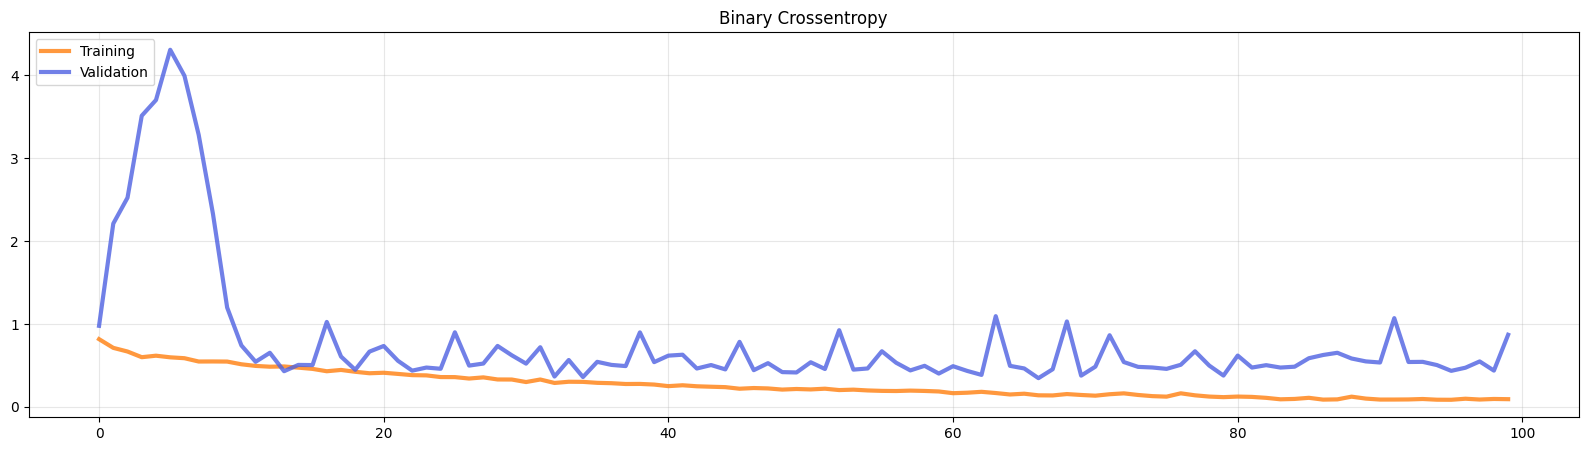

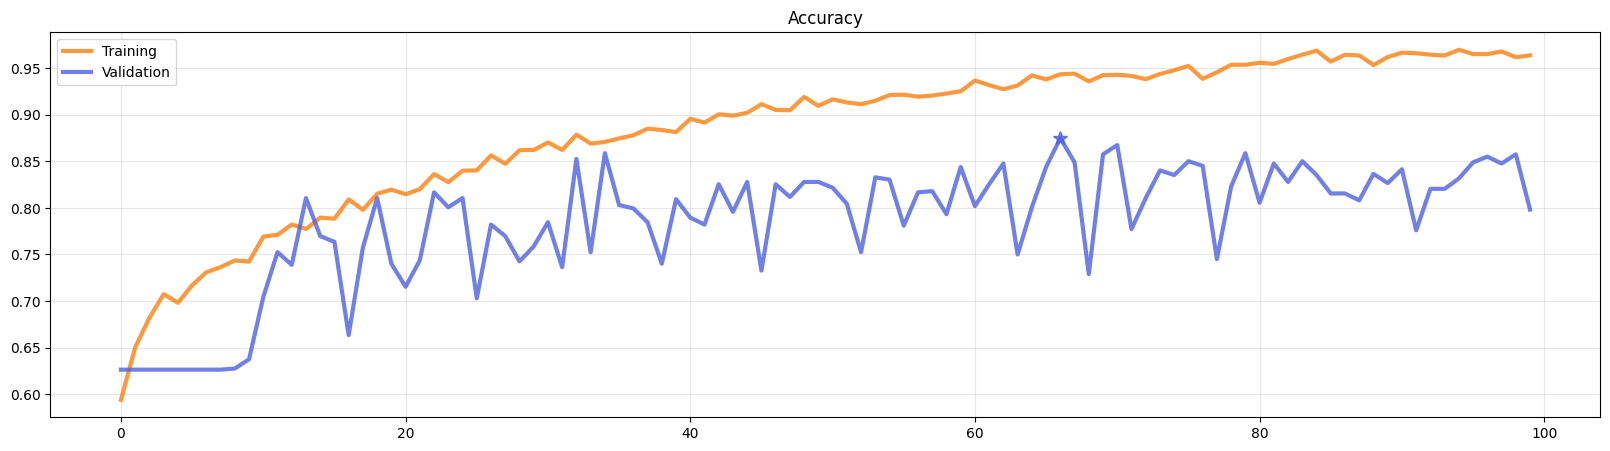

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history.history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history.history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history.history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history.history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()


In [ ]:
best_epoch

66

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)


Predictions Shape: (499, 1)


In [ ]:
binary_predictions = np.round(predictions)
print(binary_predictions)
# Compute the confusion matrix
cm = confusion_matrix(Y_test, binary_predictions)

# Compute classification metrics
accuracy = accuracy_score(Y_test, binary_predictions)
precision = precision_score(Y_test, binary_predictions)
recall = recall_score(Y_test, binary_predictions)
f1 = f1_score(Y_test, binary_predictions)

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
model.save('VGG16_New_Submission.keras')
model.save('Submission4(VGG16_New_Submission)')